# Random Forest Migraine Prediction

This notebook demonstrates migraine prediction using a Random Forest model, leveraging the modular data processing and feature engineering functions from `prediction/data_processing.py`.

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# 1. Import Libraries and Data Processing Functions
from prediction.data_processing import merge_migraine_and_weather_data, process_combined_data
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score, r2_score, mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np

## 2. Merge and Process Data
We merge the migraine and weather data, then process the combined data to engineer features and prepare it for modeling.

In [2]:
# Merge migraine and weather data (regenerate combined_data.csv)
merge_migraine_and_weather_data()

# Load and process combined data
combined_data = process_combined_data()

## 3. Prepare Features and Target for Binary Classification
We prepare the features and target variable for predicting whether a migraine occurred (binary classification).

In [3]:
features = combined_data.dropna(axis=1)  # Drop columns with any NaN values
features = features.drop(columns=[
    'Date', 'date',
    'Medication',
    'Dosage',
    'Triggers',
    'Notes',
    'Location',
    'Timezone',
    'Pain Level',
    'Pain_Level_Binary',
    'Pain_Level_Log',
    'Longitude',
    'Latitude',
    'Time',
    'Latitude_x', 'Longitude_x', 'Latitude_y', 'Longitude_y',
],
errors='ignore'
)
target_binary = combined_data['Pain_Level_Binary']

## 4. Train and Evaluate Random Forest for Binary Classification
We split the data, train a Random Forest model to predict migraine occurrence, and evaluate its performance.

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best threshold for F1: 0.26, F1: 0.71
Binary Classification Accuracy: 0.64
Binary Classification F1 Score: 0.70


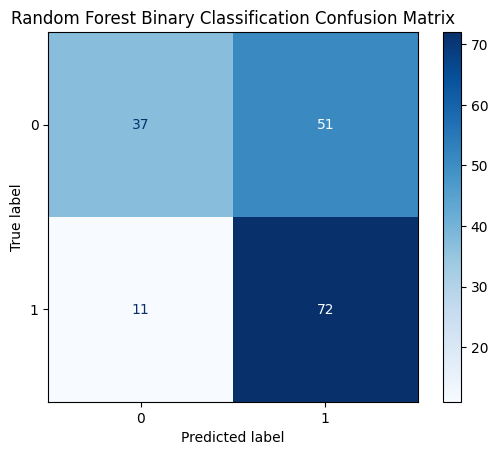

In [30]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, average_precision_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Split data
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    features, target_binary, test_size=0.2, random_state=42
)

# 2. Resample training data (SMOTE + undersampling)
resample = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('under', RandomUnderSampler(random_state=42))
])
X_train_bin_res, y_train_bin_res = resample.fit_resample(X_train_bin, y_train_bin)

# 3. Hyperparameter tuning with GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    scoring='accuracy',  # or 'f1', 'recall'
    cv=3,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train_bin_res, y_train_bin_res)
clf = grid.best_estimator_
print("Best parameters:", grid.best_params_)

# 4. Predict probabilities
y_pred_proba = clf.predict_proba(X_test_bin)[:, 1]

# 5. Precision-recall curve and best F1 threshold
precision, recall, thresholds = precision_recall_curve(y_test_bin, y_pred_proba)
ap = average_precision_score(y_test_bin, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]
print(f"Best threshold for F1: {best_threshold:.2f}, F1: {f1_scores[best_idx]:.2f}")

""" plt.figure(figsize=(8,6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AP={ap:.2f})')
plt.grid(True)
plt.show() """

# 6. Final predictions using best threshold
y_pred_bin = (y_pred_proba > best_threshold).astype(int)

# 7. Evaluation
accuracy = accuracy_score(y_test_bin, y_pred_bin)
f1 = f1_score(y_test_bin, y_pred_bin)
print(f"Binary Classification Accuracy: {accuracy:.2f}")
print(f"Binary Classification F1 Score: {f1:.2f}")

# 8. Confusion matrix
cm = confusion_matrix(y_test_bin, y_pred_bin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Random Forest Binary Classification Confusion Matrix")
plt.show()

---

## 5. Prepare Features and Target for Regression (Pain Level)
We select only the non-zero pain level cases and prepare the features and log-transformed target for regression.

In [14]:
non_zero_data = combined_data[combined_data['Pain Level'] > 0]
features_non_zero = non_zero_data.drop(columns=[
    'Date', 'date',
    'Medication',
    'Dosage',
    'Triggers',
    'Notes',
    'Location',
    'Timezone',
    'Pain Level',
    'Pain_Level_Binary',
    'Pain_Level_Log',
    'Longitude',
    'Latitude',
    'Time',
    'Latitude_x', 'Longitude_x', 'Latitude_y', 'Longitude_y',
],
errors='ignore'
)
target_non_zero = non_zero_data['Pain_Level_Log']  # Use precomputed log column

## 6. Train and Evaluate Random Forest for Regression
We split the data, train a Random Forest model to predict pain level, and evaluate its performance.

In [6]:
# Split data into training and testing sets for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(features_non_zero, target_non_zero, test_size=0.2, random_state=42)

# Train a regression model
best_params = {'bootstrap': True, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
reg = RandomForestRegressor(**best_params)
reg.fit(X_train_reg, y_train_reg)

# Make predictions for regression
y_pred_reg = reg.predict(X_test_reg)

# Evaluate the regression model
r2 = r2_score(y_test_reg, y_pred_reg)
mae = mean_absolute_error(y_test_reg, y_pred_reg)
mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)

print(f"Regression Model R^2 score: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Regression Model R^2 score: 0.14492176055411998
Mean Absolute Error (MAE): 0.2120808445065962
Mean Squared Error (MSE): 0.07579712617277667
Root Mean Squared Error (RMSE): 0.2753127788039935


## 7. Feature Importance for Regression Model
We examine which features are most important for predicting pain level using the trained Random Forest regressor.

In [15]:
feature_importances = reg.feature_importances_
feature_names = features_non_zero.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Feature importances for regression model:")
print(importance_df)

Feature importances for regression model:
                  Feature  Importance
36            humid.*tavg    0.218023
8         midday_humidity    0.108629
35              tavg_lag2    0.074267
7        average_humidity    0.062354
38       pres_change_lag2    0.059817
5                    wspd    0.059684
9             pres_change    0.049002
37       pres_change_lag1    0.046409
0                    tavg    0.045877
3                    pres    0.041404
34              tavg_lag1    0.034301
2                    tmax    0.030391
1                    tmin    0.029187
33                  tdiff    0.025634
16            DayOfWeek_6    0.014398
4                    prcp    0.012616
28               Month_12    0.009320
31  Physical Activity_0.0    0.007646
19                Month_3    0.006646
14            DayOfWeek_4    0.005949
20                Month_4    0.005717
32  Physical Activity_1.0    0.005534
11            DayOfWeek_1    0.004662
29              Sleep_1.0    0.004269
17      